# Projeto do Módulo de NLP
## No projeto do módulo de NLP vamos tentar resolver um problema de classificação de textos.

---


### Você escolherá um de três datasets cujo objetivo é classificar em um conjunto de classes.
### Você deverá utilizar três metodologias ensinadas em nossas aulas para poder classificar esses textos.
A seguir, mais detalhes do projeto para que você possa resolver.
Os produtos finais deste projeto será um Notebook Python.

As seções seguintes detalham como você deve proceder para gerar o código e a última seção deve especificar a estrutura que seu notebook deve seguir.

---
## 1. Dados
Você poderá escolher três tarefas para resolver no projeto. <a href="#dados"><b>Ver</b></a>
## 2. Representação
Vimos durante a nossa aula diversas forma de representar um documento de texto. Você vai usar cada uma dessas representações e compará-las. <a href="#representa"><b>Ver</b></a>
## 3. Visualização dos dados
Também vimos que embora o nosso texto apresente dimensionalidade maior que 2D, é
possível visualizar em apenas duas dimensões usando técnicas de redução de dimensionalidade. Vimos duas técnicas de redução de dimensionalidade, o PCA e o t-SNE. <a href="#visualiza"><b>Ver</b></a>
## 4. Classificadores
Escolha dois classificadores que você possua mais familiaridade no scikit-learn para poder classificar os seus dados. <a href="#classifica"><b>Ver</b></a>
## 5. Métricas de avaliação
Para os corpus TweetSentBR e UTL, pede-se que se use a matriz de confusão, a precisão, o recall e o f-1 para reportar a acurácia dos seus classificadores.  <a href="#metricas"><b>Ver</b></a>
## 6. Estrutura do Notebook
O seu notebook deve ser dividido por seções que possuam uma célula do tipo Markdown.  <a href="#tarefas"><b>Ver</b></a>

---

### Importando as bibliotecas necessárias e a classe Document.

In [1]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, mpld3 
from mpl_toolkits.mplot3d import Axes3D

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import spacy
from hunspell import Hunspell

from src.base.document import Document as doc

import os
from os import listdir
from os.path import join

from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, Word2Vec
from gensim.corpora import Dictionary

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

%matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\TOP
[nltk_data]     Artes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\TOP
[nltk_data]     Artes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\TOP
[nltk_data]     Artes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Especificando o caminho da pasta com os dados e listando os nomes de cada conjunto de textos.

In [2]:
# 'Seta' o caminho das imagens
folder_path = "data/"

# Lista das pastas no path
folders = os.listdir(folder_path)

<a name="dados"></a>
### 1. Dados
A seguir existe a breve descrição de cada tarefa e um link para onde você poderá baixar os dados.

> a) O corpus UTL é um corpus com críticas de filmes e apps coletadas
automaticamente de sites. As classes são: positiva ou negativa. Assim o usuário
pode ter gostado ou não gostado do produto. Referência:
https://github.com/RogerFig/UTLCorpus .

><a name="b"></a> b) O corpus UOL AES-PT é um corpus de redações no estilo do ENEM. Cada
redação possui um tópico e um conjunto de redações relacionadas. Nesse
corpus, existem vários tópicos e suas respectivas redações. O objetivo é
predizer a nota final de cada redação de acordo com o grupo de notas 0, 200,
400, 600, 800 e 1000. Para mais informações e download dos dados, acesse o
link: https://github.com/evelinamorim/aes-pt .

> c) O corpus TweetSentBr é um corpus em português de tweets. Cada tweet está
rotulado com uma das classes: positivo, negativo e neutro. Para mais
informações e download do corpus, acesse o link
https://bitbucket.org/HBrum/tweetsentbr/src/master/ .

---

### Função criada para definir os rótulos.

In [3]:
def define_label(nota:float)->int:
    """
    Recebe o finalgrade do documento, de 0 a 10 e retorna o label.
    O label é definido pela nota/finalgrade:
    nota <= 1 -> label = 0
    nota > 1 e <= 3 -> label = 200
    nota > 3 e <= 5 -> label = 400
    nota > 5 e <= 7 -> label = 600
    nota > 7 e <= 9 -> label = 800
    nota > 9 -> label = 1000
    """
    if (nota <= 1.):
        return 0
    elif (nota > 1. and nota <= 3.):
        return 200
    elif (nota > 3. and nota <= 5.):
        return 400
    elif (nota > 5. and nota <= 7.):
        return 600
    elif (nota > 7. and nota <= 9.):
        return 800
    else:
        return 1000
        

### A base de dados escolhida foi o <a href="#b">Corpus UOL AES-PT</a>
O código abaixo percorre as pastas lendo os arquivos e define os rótulos para treinamento. Tendo a lista com algumas das propriedades de cada documento a proposta de tema, a redação e quantidade de palavras, quantidade de paragrafos são algumas das features extraidas que serão utilizadas para o treinamento do modelo de classificação.

In [4]:
data, labels = [],[]

# Define a lista de palavras com significados menos relevantes para o modelo
stop_words = stopwords.words('portuguese')
stp_words = stop_words+' '.join(string.punctuation).split(' ')+["``","''","“",'”']

# Percorre as pastas e lê os nomes
for folder in folders:
    
    # Verifica se é pasta válida
    if folder.startswith(".") or "." in folder:
        continue
        
    for file_promp in os.listdir(os.path.join(folder_path,folder)):
        
        # Verifica se é um arquivo válido (XML)
        if file_promp.endswith(".xml") and not file_promp.startswith("."):

            # Instancia o documento
            prompt = doc(os.path.join(folder_path,folder,file_promp))
    
            # Lê os documentos da base
            doc.read(prompt)
            
            # Processa as Propostas de Redação
            doc.read_prompt(prompt, os.path.join(folder_path,folder,file_promp))
            
            # Define o Título da Proposta
            pro_title = doc.get_prompttitle(prompt).lstrip().rstrip()
            
            # Define a Proposta
            pro_text = doc.get_promptbody(prompt).lstrip().rstrip()
        
    
    # Percorre os arquivos contidos na pasta e instancia o documento
    for file in os.listdir(os.path.join(folder_path,folder,"xml")):

        # Verifica se é um arquivo válido (XML)
        if file.endswith(".xml") and not file.startswith("."):

            # Instancia o documento
            document = doc(os.path.join(folder_path,folder,"xml",file))
    
            # Lê os documentos da base
            doc.read(document)
    
            # Insere as notas (finalgrades) na lista de labels
            labels.append(define_label(float(doc.get_finalgrade(document).replace(',','.'))))
    
            # Limpa os espaços extras e remove as quebras de linha do título e do texto
            title = doc.get_title(document).replace('\n','').lstrip().rstrip()
            texto = doc.get_body(document).replace('\n','').replace('``','').replace("''",'')\
            .replace(' .','.').replace(' , ',', ').replace('  ',' ').replace("'","")\
            .replace('‘','').replace('’','').replace('“','').replace('”','')\
            .lstrip().rstrip()
            
            proposta = "     ".join((pro_title, pro_text))
            redacao = "     ".join((title, texto))
            
            # Insere o texto na lista
            data.append(" ".join((proposta, redacao)))


In [5]:
def preprocess(data:np.array=[], words:bool = False, toks:bool=False, sents:bool = False, feats:bool = False):
    dct_feats = {}
    arr_titles, arr_sents, arr_words, arr_titles_promt, arr_words_promt = [],[],[],[],[]
    qtd_parag, qtd_sent, qtd_words, mean_tok = [],[],[],[]

    for i in range(len(data)):
        
        if words or feats:
            # Cria a lista de palavras dos documentos
            tok = [tok.lower().replace("'","") for tok in word_tokenize(str(data[i]))\
                     if tok.lower() not in stp_words]
            arr_words.append(tok)             
            mean_tok.append(len(tok))
        
        if sents:
            # Cria a lista de senteças dos documentos
            for sent in sent_tokenize(str(data[i])):
                arr_sents.append(simple_preprocess(sent))
        
        if feats:
            counter = 0    # Inicializa o contador
            sp_parag = str(data[i]).split("     ")    # Separa o texto pelo recuo

            # Percorre o texto separado pelo recuo de parágrafo
            for parag in sp_parag:

                # Verifica se é um paragrafo de acordo com a primeira letra
                # Se a primeira letra é maiúscula conta como novo paragrafo
                if len(parag) > 0:
                    if parag[0].isupper():
                        counter += 1   
                        
            qtd_parag.append(counter / len(str(data[i])))    # Insere a quantidade de paragrafos
            qtd_sent.append(len(sent_tokenize(str(data[i]))) / len(str(data[i])))    # Insere a quantidade de sentenças 
            qtd_words.append(len(tok) / len(str(data[i])))    # Insere a quantidade de palavras

            dct_feats = dict(parag = qtd_parag, sents = qtd_sent, words = qtd_words)
        
    
    if toks: return mean_tok
    if sents: return arr_sents
    if words: return arr_words
    if feats: return dct_feats
    
    
toks = preprocess(data, words=True, toks=True)

<a href="#1.-Dados">Voltar ao topo</a>

---

## <a name="representa"></a>  2. Representação
Vimos durante a nossa aula diversas forma de representar um documento de texto. Você vai usar cada uma dessas representações e compará-las. A seguir temos a listagem das representações que devem ser usadas para representar seu texto.

> a) Representação TF-IDF. Você pode usar tanto o gensim quanto o scikit para montar esta representação, mas lembre-se que é importante fazer o pré-processamento dos textos. <a href="#tfidf"><b>Ver</b></a>

> b) Representação com o word2vec. O modelo poderá ser o apresentado na aula 03 ou algum outro modelo pré-treinado como os existentes no repositório
http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc . Neste caso, cada documento deverá ser representado pelo vetor que resultar da média dos vetores de todas as palavras que o compõem. Em outras palavras, se D é composto
pelas palavras w1, w2, …, wn, e seus vetores embeddings são v1, v2, …, vn, então a representação do documento de D será v = (v1 + v2 + … + vn) / n. <a href="#w2v"><b>Ver</b></a>

> c) Extração de features do texto. Você deve pensar em ao menos 10 features para
extrair do documento e que o possam representar. Aqui vão algumas sugestões:
número de palavras, número de verbos, número de conjunções, número de palavras
negativas, número de palavras fora do vocabulário, quantidades de entidades do tipo PESSOA, quantidade de entidades do tipo LOCAL, etc.  <a href="#feat"><b>Ver</b></a>

Lembrando que você deve dividir seu conjunto em treino e teste. No TF-IDF, você só pode aplicar o método fit no conjunto de treino. Uma sugestão é dividir 80% do conjunto de dados para treino e 20% para teste. Essa divisão é aleatória, mas você pode usar o método train_test_split para essa divisão. O exemplo a seguir mostra como usar esse método:

> `from sklearn.model_selection import train_test_split`

> `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20 , random_state = 42 )`

#### Verificando a quantidade de rótulos e textos.

In [6]:
X = np.array(data).reshape(-1,1)
y = np.array(labels).reshape(-1,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1472, 1), (1472,), (368, 1), (368,))

---
### <a name="tfidf"></a> Representação TF-IDF (Term Frequency-Inverse Document Frequency)

A representação abaixo é uma medida estatística calculada a partir da frequência de cada termo e tem o intuito de indicar a importância de cada palavra do documento em relação à coleção de documentos.

In [7]:
arr_words = preprocess(X_train, words=True)

dct_text = Dictionary(arr_words)

# Cria o 'bow' de cada documento
bow_text = [dct_text.doc2bow(line) for line in arr_words]

# Calcula a representação Tf-idf de cada documento
model_tfidf = TfidfModel(bow_text)

In [8]:
model_tfidf[bow_text[0]]

[(0, 0.0437524178657381),
 (1, 0.04035360885283817),
 (2, 0.046722584849319),
 (3, 0.06401677685739614),
 (4, 0.05938061758959399),
 (5, 0.06196494404832354),
 (6, 0.06295136310822805),
 (7, 0.24164105825529505),
 (8, 0.031196891862650195),
 (9, 0.03843636329834067),
 (10, 0.012305303093376392),
 (11, 0.05938061758959399),
 (12, 0.015804359347220614),
 (13, 0.05938061758959399),
 (14, 0.045564414166776625),
 (15, 0.03780240700533061),
 (16, 0.0732429582027059),
 (17, 0.10958119102417277),
 (18, 0.05372518176291828),
 (19, 0.06196494404832354),
 (20, 0.07863992831456519),
 (21, 0.05424723165678388),
 (22, 0.34330439184218864),
 (23, 0.35805972905939965),
 (24, 0.045564414166776625),
 (25, 0.007722880539953735),
 (26, 0.018060323035295235),
 (27, 0.09709229100518468),
 (28, 0.011595237892457838),
 (29, 0.06196494404832354),
 (30, 0.09119369656291523),
 (31, 0.048328211651059015),
 (32, 0.04281795944204636),
 (33, 0.08786610965987494),
 (34, 0.018561317455105263),
 (35, 0.0493936254002271

---
### <a name="w2v"></a> Representação Word2Vec

Essa representação é gerada por uma técnica de processamento de liguagem natural que utiliza um modelo de rede neural para identificar associações de palavras contidadas num corpo de texto, neste caso será utilizada a média simples dos vetores gerados pelo algorítmo.

In [9]:
arr_sents = preprocess(X_train, sents=True)

# Instancia o modelo Word2Vec
w2v_model = Word2Vec(window=10, size=300)

# Cria o vocabulário do corpus
w2v_model.build_vocab(arr_sents, progress_per=100000)

# Treina o modelo Word2Vec
#w2v_model.train(arr_sents, total_examples=w2v_model.corpus_count, epochs = 20)

arr_wv_repres = []

# Percorre a lista de palavras dos documentos
for i in range(len(arr_words)):
    arr_vector = []
    
    # Percorre a lista de palavras de um documento específico
    for j, word in enumerate(arr_words[i]):
        
        # Verifica se a palavra existe no vocabulário
        if word in list(w2v_model.wv.vocab.keys()):
            arr_vector.append(w2v_model.wv[word])
            
    # Calcula a média dos vetores de um documento específico
    arr_wv_repres.append(np.mean(arr_vector))

In [10]:
print(f"Representação Word2vec: {len(arr_wv_repres)} documentos\n\n\
Visualizando a representação dos 5 primeiros documentos\n\
{arr_wv_repres[:5]}") # Imprime o tamanho e os 10 primeiros valores

Representação Word2vec: 1472 documentos

Visualizando a representação dos 5 primeiros documentos
[-6.8497284e-06, 1.25337e-05, 4.188371e-06, 4.3306745e-06, -2.1312442e-06]


---
### <a name="feat"></a> Extração de features

A extração das features foi realizada por meio de algumas bibliotecas como [SpaCy](https://spacy.io/models/pt) para pré-processar cada corpo de texto e classificar suas entidades, [Hunspell](https://pypi.org/project/cyhunspell/) juntamente com o dicionário 'pt_BR' para identificar erros ortográficos e 'bias_words.txt' para classificar léxicos enviesados.

A features extraidas foram dividas pelo tamaho do documento, "feature / len(doc)".

In [11]:
def get_features(data:np.array)->dict:
    
    dct_feats = {}
    dct_feats = preprocess(data, feats=True)
    
    nlp = spacy.load('pt')

    # Define o caminho da pasta para o dicionário ortográficos
    PATH_TO = '/nlp/Projeto/aes-pt-master/dict'
    # Carrega o dicionário ortográfico
    hobj = Hunspell('pt_BR','pt_BR.aff', hunspell_data_dir=PATH_TO)

    # Extraindo a quantidade de léxicos enviesados
    dct_vies = {
        'argumentativo':[],
        'pressuposicao':[],
        'possibilidade_necessidade':[],
        'opiniao_valoracao':[]}

    # Lê o dicionário de léxicos enviesadas
    fd_dicionario_vies = open("dict/bias_words.txt","r", encoding='utf-8')

    # Percorre o dicionário classificando cada termo
    for line in fd_dicionario_vies:
        entry = line.replace("\n","").split(",")
        term = entry[0].strip()
        type_term = entry[1].strip()
        dct_vies[type_term].append(term)

    # Listas dos tipos de léxicos enviesados
    arr_arg, arr_press, arr_pos_nec, arr_op_val = [],[],[],[]

    # Listas das quantidades dos tipos de entidades
    arr_per, arr_loc, arr_org, arr_misc = [],[],[],[]

    # Listas de grupos por tamanho das sentenças
    arr_sent5, arr_sent5_10, arr_sent10 = [],[],[]

    # Listas das quantidade de caracteres e erros ortográficos
    arr_erros, arr_chars = [],[]

    # Listas de pos tagging
    arr_verb, arr_adj, arr_noun, arr_adv = [],[],[],[]

    for i in range(len(data)):

        # Istancia o documento spacy
        doc = nlp(str(data[i]))

        # Contadores de palavras na sentença
        qtd_sent5, qtd_sent5_10, qtd_sent10 = 0,0,0

        # Separa o texto pelas sentenças
        for sent in sent_tokenize(doc.text):

            # Cria o array de tokens excluindo acentuação e stopword
            arr_tok = [word for word in word_tokenize(sent)\
                       if word not in stop_words+["``","''","“",'”']]

            # Verifica o quantidade de tokens na senteça
            if (len(arr_tok) <= 5):
                # Conta as sentenças com 5 ou menos tokens
                qtd_sent5 += 1

            elif (len(arr_tok) > 10):
                # Conta as sentenças com mais de 10 tokens
                qtd_sent10 += 1
            else:
                # Conta as sentenças com 5 a 10 tokens
                qtd_sent5_10 += 1            

        arr_sent5.append(qtd_sent5 / len(doc))
        arr_sent5_10.append(qtd_sent5_10 / len(doc))
        arr_sent10.append(qtd_sent10 / len(doc))

        # Contadores de cada tipo de entidade
        qtd_per, qtd_loc, qtd_org, qtd_misc = 0,0,0,0
        for entidy in doc.ents:
            if entidy.label_ == 'PER':
                qtd_per += 1
            elif entidy.label_ == 'LOC':
                qtd_loc += 1
            elif entidy.label_ == 'ORG':
                qtd_org += 1
            elif entidy.label_ == 'MISC':
                qtd_misc += 1

        arr_per.append(qtd_per / len(doc))
        arr_loc.append(qtd_loc / len(doc))
        arr_org.append(qtd_org / len(doc))
        arr_misc.append(qtd_misc / len(doc))

        # Contadores de erros ortográficos e caracteres
        qtd_erro, qtd_char = 0, 0

        for tok in doc:
            if tok.text not in stop_words+["–","—"]:

                token = tok.text
                qtd_char += len(token)

                if not (hobj.spell(token)):
                    qtd_erro += 1

        arr_erros.append(qtd_erro / len(doc))
        arr_chars.append(qtd_char / len(doc))

        for type_term in dct_vies:
            qtd_arg, qtd_pres, qtd_poss, qtd_opin = 0,0,0,0
            for term in dct_vies[type_term]:
                for sent in doc.sents:
                    if term in sent.text.lower():
                        if type_term == "argumentativo":
                            qtd_arg += 1
                        elif type_term == "pressuposicao":
                            qtd_pres += 1
                        elif type_term == "possibilidade_necessidade":
                            qtd_poss += 1
                        elif type_term == "opiniao_valoracao":
                            qtd_opin += 1

        arr_arg.append(qtd_arg / len(doc))
        arr_press.append(qtd_pres / len(doc))
        arr_pos_nec.append(qtd_poss / len(doc))
        arr_op_val.append(qtd_opin / len(doc))

        qtd_verb, qtd_adj, qtd_noun, qtd_adv = 0,0,0,0
        for tok in doc:
            if tok.pos_ == 'VERB':
                qtd_verb += 1
            if tok.pos_ == 'ADJ':
                qtd_adj += 1
            if tok.pos_ == 'NOUN':
                qtd_noun += 1
            if tok.pos_ == 'ADV':
                qtd_adv += 1

        arr_verb.append(qtd_verb / len(doc))
        arr_adj.append(qtd_adj / len(doc))
        arr_noun.append(qtd_noun / len(doc))
        arr_adv.append(qtd_adv / len(doc))        
    

    dct_feats["sent5"] = arr_sent5
    dct_feats["sent5_10"] = arr_sent5_10
    dct_feats["sent10"] = arr_sent10
    
    dct_feats["erros"] = arr_erros
    dct_feats["chars"] = arr_chars

    dct_feats["per"] = arr_per
    dct_feats["loc"] = arr_loc
    dct_feats["org"] = arr_org
    dct_feats["misc"] = arr_misc
    
    dct_feats["arg"] = arr_arg
    dct_feats["press"] = arr_press
    dct_feats["pos_nec"] = arr_pos_nec
    dct_feats["op_val"] = arr_op_val
    
    dct_feats["verb"] = arr_verb
    dct_feats["adj"] = arr_adj
    dct_feats["noun"] = arr_noun
    dct_feats["adv"] = arr_adv
    
    return dct_feats

dct_fts = get_features(X_train)

In [12]:
df_feats = pd.DataFrame.from_dict(dct_fts)
df_feats.head()

,parag,sents,words,sent5,sent5_10,sent10,erros,chars,per,loc,org,misc,arg,press,pos_nec,op_val,verb,adj,noun,adv
0,0.001080,0.006479,0.091433,0.001946,0.003891,0.029183,0.085603,3.667315,0.003891,0.001946,0.001946,0.001946,0.0,0.0,0.0,0.031128,0.134241,0.050584,0.254864,0.044747
1,0.001055,0.004747,0.092300,0.000000,0.005155,0.018041,0.103093,3.000000,0.000000,0.002577,0.000000,0.002577,0.0,0.0,0.0,0.023196,0.146907,0.036082,0.198454,0.082474
2,0.002113,0.008099,0.090845,0.001862,0.003724,0.037244,0.109870,3.700186,0.003724,0.005587,0.000000,0.000000,0.0,0.0,0.0,0.039106,0.117318,0.055866,0.227188,0.039106
3,0.001086,0.007239,0.083605,0.002012,0.006036,0.032193,0.078471,3.796781,0.002012,0.006036,0.002012,0.002012,0.0,0.0,0.0,0.014085,0.116700,0.062374,0.235412,0.016097
4,0.000953,0.007942,0.090216,0.001642,0.011494,0.027915,0.100164,3.456486,0.003284,0.003284,0.000000,0.000000,0.0,0.0,0.0,0.031199,0.093596,0.049261,0.228243,0.042693


<a name="tarefa1"></a>

# 1) Tarefa e Dados: <a href="#1">Tarefa 1</a>

Descreva a tarefa escolhida e os dados. Escreva código que leia os dados e calcule e imprima quantas instâncias os dados têm. Também, seu código deve calcular a média de tokens por instância, isto é, quantos tokens, na média cada documento do seu conjunto de dados possui. Imprima esse único número.

A tarefa escolhida foi a classificação de redações no estilo do ENEM.
O objetivo é classificar cada redação de acordo com o grupo de notas 0, 200, 400, 600, 800 e 1000.
O Corpus possui 1840 instâncias e a média de tokens por documento é 226,85.

In [13]:
print(f'Quantidade de instâncias do Corpus: {len(data)}')
print(f'Média de tokens por documento: {np.mean(toks)}')

Quantidade de instâncias do Corpus: 1840
Média de tokens por documento: 226.85326086956522


<a href="#1.-Dados">Voltar ao topo</a>

---
## <a name="visualiza"></a>3. Visualização dos dados
Também vimos que embora o nosso texto apresente dimensionalidade maior que 2D, é
possível visualizar em apenas duas dimensões usando técnicas de redução de
dimensionalidade. Vimos duas técnicas de redução de dimensionalidade, o PCA e o t-SNE.
Assim, pede-se que você utilize as duas técnicas para gerar uma visualização dos seus dados e considere as classes para colorir as instâncias.

Sugere-se utilizar a biblioteca yellowbrick para gerar as visualizações, devido sua simplicidade.
Mas caso tenha interesse em gerar visualizações mais interativas e mais  bonitas, você pode utilizar a biblioteca seaborn. Para uma galeria dos gráficos que o seaborn é capaz de fazer, acesse o link https://seaborn.pydata.org/examples/index.html . Apenas acrescentando em seu código `import seaborn as sns ; sns . set()`, também é possível deixar o gráfico com cores
mais bonitas. Todas essas bibliotecas precisam do matplotlib, que já está importado no
exemplo da aula.

Aqui você deve fazer a visualização apenas do seu conjunto de treino.

#### Visualizando a representação [Sklearn Tfidf Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) dos dados de treino com a redução de dimensionalidade [Sklearn PCA Decomposition](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) .

In [14]:
# Cria o vetor de significância das palavras do corpus excluindo as 'stopwords'
vec = TfidfVectorizer(stop_words=stop_words)

# Transforma o vetor em matriz
matrix = vec.fit_transform(X_train.reshape(-1))
matrix.data

array([0.05800214, 0.0486443 , 0.06668469, ..., 0.04422693, 0.06616516,
       0.0311349 ])

Criando os rótulos das classes

In [15]:
cluster = y_train.copy()

cluster[cluster==0]=0
cluster[cluster==200]=1
cluster[cluster==400]=2
cluster[cluster==600]=3
cluster[cluster==800]=4
cluster[cluster==1000]=5

scaler = StandardScaler(with_mean=False)
matrix = scaler.fit_transform(matrix)
classes = list(np.unique(np.sort(y_train)))

## TF-IDF - PCA
Visualizando os dados de treino em 2 dimensões.

In [16]:
pca = PCA(n_components=2)
pc_tfidf = pca.fit_transform(matrix.toarray())
df_pc_tfidf = pd.DataFrame(data = pc_tfidf, 
        columns = ['PC1', 'PC2'])
df_pc_tfidf['Cluster'] = cluster
df_pc_tfidf.head()

,PC1,PC2,Cluster
0,-0.933083,-0.596313,3
1,0.810857,-0.266482,2
2,-1.120652,0.299312,2
3,-0.980940,-0.588339,2
4,-0.182800,-0.513883,2


Visualizando o gráfico de dispesão da Representação TF-IDF

c:\users\top artes\.conda\envs\keras_tf2\lib\site-packages\mpld3\mplexporter\exporter.py:267: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]


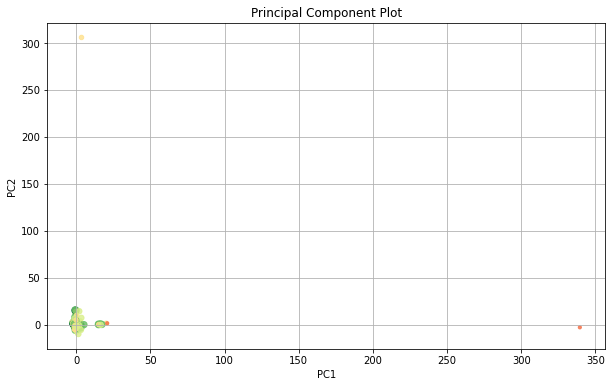

In [17]:
mpld3.enable_notebook()
fig, ax = plt.subplots(figsize=(10,6))

scatter = ax.scatter(x='PC1', y='PC2', data=df_pc_tfidf,
                     c='Cluster', alpha=0.8, s=cluster*10,
                     cmap=plt.get_cmap("RdYlGn"))

N = len(df_pc_tfidf)
lab = ["Linha %d" % d for d in range(N)]

fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, lab)

mpld3.plugins.connect(fig, tooltip)
ax.set(title="Principal Component Plot", xlabel="PC1", ylabel="PC2")
plt.grid()
plt.show()

Aparentemente existem 2 outliers na representação, abaixo eles serão identificados afim de verificar possíveis padrões, ou anomalias nos dados.

Visualizando sem os outliers identificados.

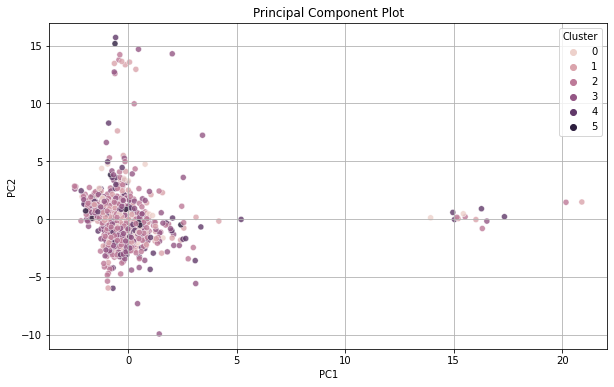

In [18]:
mpld3.disable_notebook()
fig, ax = plt.subplots(figsize=(10,6))

scatter = sns.scatterplot(x='PC1', y='PC2',
                          data=df_pc_tfidf.drop([305,1408], axis=0, inplace=False),
                          alpha=0.8, hue='Cluster', ax=ax)
ax.set(title="Principal Component Plot", xlabel="PC1", ylabel="PC2")

plt.grid()
plt.show()

In [19]:
df_explain = pd.DataFrame({'var':pca.explained_variance_ratio_,
                           'PC':['PC1','PC2']})

Visualizando a Variância Acumulada dos componentes principais sem os outliers identificados acima.

c:\users\top artes\.conda\envs\keras_tf2\lib\site-packages\mpld3\_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
c:\users\top artes\.conda\envs\keras_tf2\lib\site-packages\mpld3\_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)


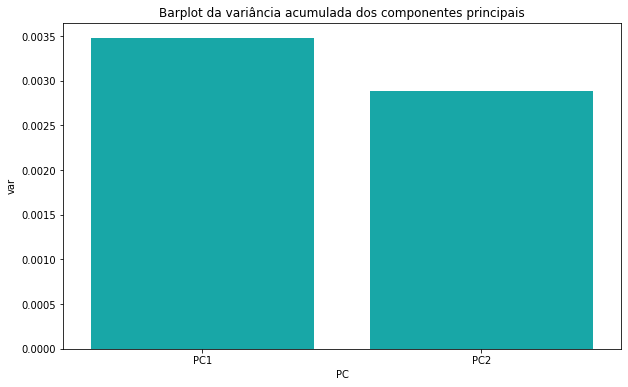

In [20]:
mpld3.enable_notebook()
plt.figure(figsize=(10,6))

ax = sns.barplot(x='PC',y="var", data=df_explain,
            color="c")

ax.set(title = "Barplot da variância acumulada dos componentes principais")
plt.show()

## TF-IDF - TSNE

Visualizando os dados de treino em 2 dimensões.

In [21]:
tsne = TSNE(n_components=2, random_state=0)
tfidf_tsne = tsne.fit_transform(matrix.toarray())

In [22]:
df_tfidf_tsne = pd.DataFrame(columns=['COMP1','COMP2'],
                       data=tfidf_tsne)

In [23]:
df_tfidf_tsne['Cluster'] = cluster

c:\users\top artes\.conda\envs\keras_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


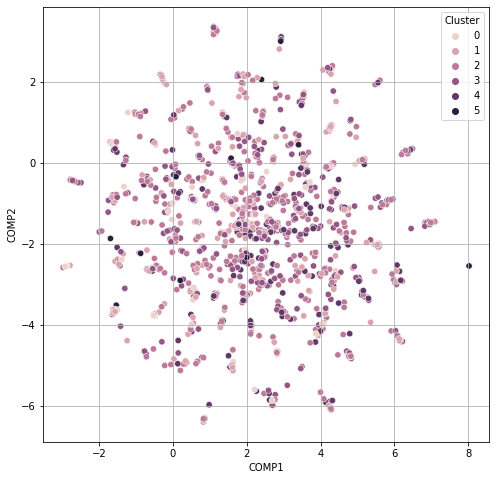

In [24]:
mpld3.disable_notebook()

# Compare com o gráfico do PCA acima e também com o do 
# tsne do outro
plt.figure(figsize=(8,8))
ax = plt.subplot()

lst_labels = sorted(np.unique(labels))

sns.scatterplot(df_tfidf_tsne['COMP1'], df_tfidf_tsne['COMP2'],hue=df_tfidf_tsne['Cluster'],
                lw=0, s=40)

plt.grid()
plt.show()

---
## PCA da Representação WordToVec
Visualizando a representação Word2vec dos dados de treino.

In [25]:
def word_vectorize(arr_words:np.array=[]):
    EMBEDDING_SIZE = 300
    arr_wv = []

    # Percorre a lista de palavras dos documentos
    for i in range(len(arr_words)):
        arr_vector = []
        ntok = 0
        doc = np.zeros((EMBEDDING_SIZE,))
        # Percorre a lista de palavras de um documento específico
        for j, word in enumerate(arr_words[i]):

            # Verifica se a palavra existe no vocabulário
            if word in list(w2v_model.wv.vocab.keys()):
                doc = np.add(doc, w2v_model.wv[word])
                ntok += 1
        doc = doc / ntok
        # Calcula a média dos vetores de um documento específico
        arr_wv.append(doc)
    return arr_wv

In [26]:
pca = PCA(n_components=2)
pca_wv = pca.fit_transform(word_vectorize(arr_words))
df_pca_wv = pd.DataFrame(columns = ['PC1', 'PC2'], data = pca_wv)
df_pca_wv['Cluster'] = cluster
df_pca_wv.head()

,PC1,PC2,Cluster
0,0.000079,0.000476,3
1,-0.000124,-0.000033,2
2,0.000097,0.000443,2
3,0.000061,-0.000141,2
4,-0.000214,0.000024,2


In [27]:
df_pca_wv.shape

(1472, 3)

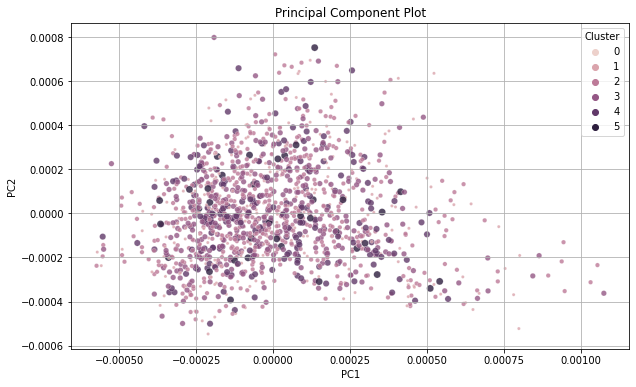

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

scatter = sns.scatterplot(x='PC1', y='PC2', data=df_pca_wv, s=cluster*10,
                          alpha=0.8, hue='Cluster', ax=ax)
ax.set(title="Principal Component Plot", xlabel="PC1", ylabel="PC2")

plt.grid()
plt.show()

## TSNE da Representação WordToVec
Visualizando a representação Word2vec dos dados de treino.

In [29]:
tsne = TSNE(n_components=2, random_state=0)
df_tsne_wv = tsne.fit_transform(word_vectorize(arr_words))
df_tsne_wv = pd.DataFrame(data=df_tsne_wv, columns=['COMP1', 'COMP2'])
df_tsne_wv['Cluster'] = cluster

c:\users\top artes\.conda\envs\keras_tf2\lib\site-packages\mpld3\mplexporter\exporter.py:267: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
c:\users\top artes\.conda\envs\keras_tf2\lib\site-packages\mpld3\_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)


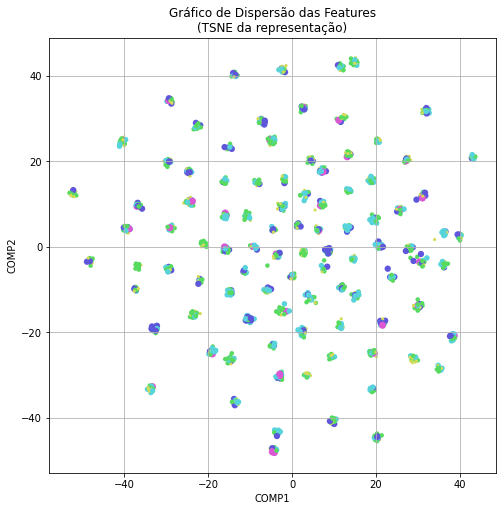

In [30]:
mpld3.enable_notebook()
# Compare com o gráfico do PCA acima e também com o do 
# tsne do outro
plt.figure(figsize=(8,8))
ax = plt.subplot()

colors_tsne = np.array(cluster)
# duas classes apenas
num_classes = len(np.unique(cluster))
# pegando emprestado do seaborn uma paleta de cores
palette = np.array(sns.color_palette("hls", num_classes))

sc = ax.scatter(df_tsne_wv.COMP1,df_tsne_wv.COMP2, 
                lw=0, s=cluster*10, c=palette[colors_tsne.astype(np.int)])

ax.set(xlabel='COMP1', ylabel='COMP2',
      title='Gráfico de Dispersão das Features\n(TSNE da representação)')
fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels)
plt.grid()

mpld3.plugins.connect(fig, tooltip)

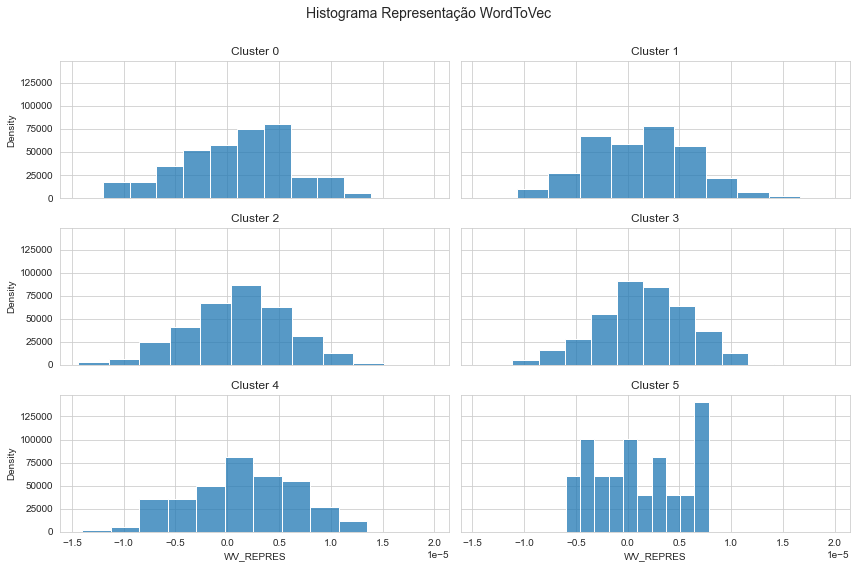

In [31]:
df_wv = pd.DataFrame(data=arr_wv_repres, columns=['WV_REPRES'])
df_wv['Cluster'] = cluster

mpld3.disable_notebook()
with sns.axes_style('whitegrid'):
    
    fig, ax = plt.subplots(3,2,figsize=(12,8), sharey=True, sharex=True)
    
    fig.suptitle('Histograma Representação WordToVec\n',fontsize=14)

    sns.histplot(x='WV_REPRES', data=df_wv[df_wv['Cluster']==0],
                 stat='density', ax=ax[0,0], bins=10)
    ax[0,0].set(xlabel='',
               title='Cluster 0')

    sns.histplot(x='WV_REPRES', data=df_wv[df_wv['Cluster']==1],
                 stat='density', ax=ax[0,1], bins=10)
    ax[0,1].set(xlabel='', ylabel='',
               title='Cluster 1')

    sns.histplot(x='WV_REPRES', data=df_wv[df_wv['Cluster']==2],
                 stat='density', ax=ax[1,0], bins=10)
    ax[1,0].set(xlabel='',
               title='Cluster 2')

    sns.histplot(x='WV_REPRES', data=df_wv[df_wv['Cluster']==3],
                 stat='density', ax=ax[1,1], bins=10)
    ax[1,1].set(xlabel='', ylabel='',
               title='Cluster 3')

    sns.histplot(x='WV_REPRES', data=df_wv[df_wv['Cluster']==4],
                 stat='density', ax=ax[2,0], bins=10)
    ax[2,0].set(title='Cluster 4')

    sns.histplot(x='WV_REPRES', data=df_wv[df_wv['Cluster']==5],
                 stat='density', ax=ax[2,1], bins=10)
    ax[2,1].set(ylabel='',
               title='Cluster 5')
    
    plt.tight_layout()
    plt.show()

## PCA das Features Extraídas
Visualizando as Features extraidas.

In [32]:
df_feats_pca = pca.fit_transform(df_feats)

In [33]:
df_feats_pca = pd.DataFrame(data = df_feats_pca, 
        columns = ['PC1', 'PC2'])
df_feats_pca['Cluster'] = cluster
df_feats_pca.head()

,PC1,PC2,Cluster
0,-0.034064,-0.028388,3
1,0.636099,-0.001793,2
2,-0.065834,0.004127,2
3,-0.163636,-0.024468,2
4,0.177120,-0.018334,2


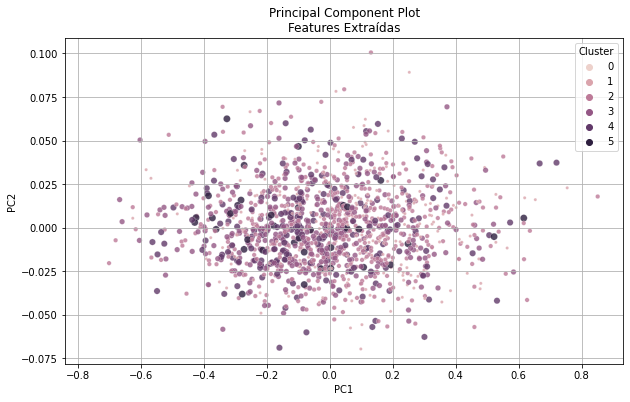

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(x='PC1', y='PC2', data=df_feats_pca, s=cluster*10,
                          alpha=0.8, hue='Cluster', ax=ax)
ax.set(title="Principal Component Plot\nFeatures Extraídas", xlabel="PC1", ylabel="PC2")

plt.grid()
plt.show()

## TSNE das Features Extraídas

c:\users\top artes\.conda\envs\keras_tf2\lib\site-packages\mpld3\mplexporter\exporter.py:267: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
c:\users\top artes\.conda\envs\keras_tf2\lib\site-packages\mpld3\_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)


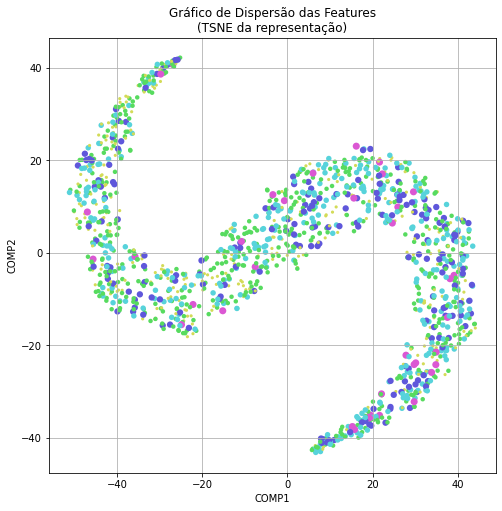

In [35]:
tsne = TSNE(n_components=2, random_state=0)
df_feats_tsne = tsne.fit_transform(df_feats)

mpld3.enable_notebook()
# Compare com o gráfico do PCA acima e também com o do 
# tsne do outro
plt.figure(figsize=(8,8))
ax = plt.subplot()

colors_tsne = np.array(cluster)
# duas classes apenas
num_classes = len(np.unique(cluster))
# pegando emprestado do seaborn uma paleta de cores
palette = np.array(sns.color_palette("hls", num_classes))

sc = ax.scatter(df_feats_tsne[:,0], df_feats_tsne[:,1],
                lw=0, s=cluster*10, c=palette[colors_tsne.astype(np.int)])

ax.set(xlabel='COMP1', ylabel='COMP2',
      title='Gráfico de Dispersão das Features\n(TSNE da representação)')
fig = plt.gcf()
tooltip = mpld3.plugins.PointLabelTooltip(sc, labels)

mpld3.plugins.connect(fig, tooltip)
plt.grid()
plt.show()

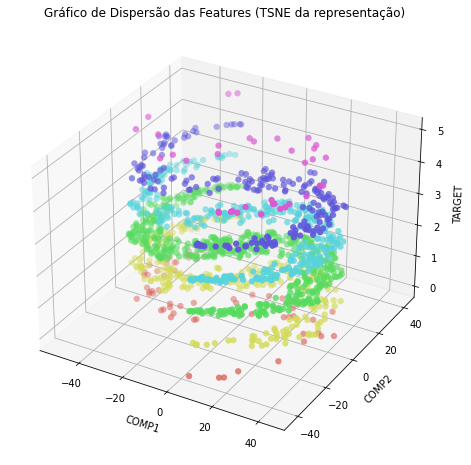

In [36]:
mpld3.disable_notebook()

plt.figure(figsize=(8,8))
ax = plt.subplot(projection='3d')

colors_tsne = np.array(cluster)
# duas classes apenas
num_classes = len(np.unique(cluster))
# pegando emprestado do seaborn uma paleta de cores
palette = np.array(sns.color_palette("hls", num_classes))

ax.scatter(df_feats_tsne[:,0], df_feats_tsne[:,1], cluster,
                lw=0, s=40, c=palette[colors_tsne.astype(np.int)])

ax.set(xlabel='COMP1', ylabel='COMP2', zlabel='TARGET',
      title='Gráfico de Dispersão das Features (TSNE da representação)')

plt.grid()
plt.show()

<a name='tarefa2'></a>
# 2) Visualização dos dados: <a href="#2">Tarefa 2</a>

## Coloque nesta seção os gráficos do PCA e do t-SNE, para cada representação. Responda também às seguintes perguntas:

### a) Existe algum padrão com relação às classes?
Aparentemente não há um padrão dos dados em relação às classes em nenhuma das representações.
### b) Caso exista algum padrão, você pode concluir alguma coisa?

### c) Caso não exista, você consegue dizer se isso tem a ver com alguma representação ou classe?
As representações, com suas metodologias específicas, não conseguiram encontrar padrões entre as classes, resultando em dados esparsos sem indícios de similaridades nos dados de cada classe.

<a href="#1.-Dados">Voltar ao topo</a>

---

<a name='classifica'></a>
## 4. Classificadores
Escolha dois classificadores que você possua mais familiaridade no scikit-learn para poder classificar os seus dados. Você deve executar cada um dos classificadores nas três representações escolhidas.

Você pode usar o k-nn como um dos métodos. Outros métodos estão disponíveis no scikit, como por exemplo o SVM e o RandomForest.

In [37]:
clf_rfc = make_pipeline(StandardScaler(), RandomForestClassifier())
clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

## Classificação Tf-idf

In [38]:
matrix_test = vec.fit_transform(X_test.reshape(-1))
matrix_test = scaler.fit_transform(matrix_test)
df_tfidf_test = pd.DataFrame(matrix_test.toarray())
tfidf_tsne_test = tsne.fit_transform(df_tfidf_test)

In [39]:
clf_rfc.fit(df_tfidf_tsne[['COMP1','COMP2']], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [40]:
pred_tfidf_rfc = clf_rfc.predict(tfidf_tsne_test)

In [41]:
clf_svc.fit(df_tfidf_tsne[['COMP1','COMP2']], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [42]:
pred_tfidf_svc = clf_svc.predict(tfidf_tsne_test)

## Classificação WordToVec

In [43]:
wv_test = word_vectorize(preprocess(X_test, words=True))
wv_tsne_test = tsne.fit_transform(wv_test)

In [44]:
clf_rfc.fit(df_tsne_wv[['COMP1','COMP2']], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [45]:
pred_wv_rfc = clf_rfc.predict(wv_tsne_test)

In [46]:
clf_svc.fit(df_tsne_wv[['COMP1','COMP2']], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [47]:
pred_wv_svc = clf_svc.predict(wv_tsne_test)

## Classificação das Features Extraídas

In [48]:
dct_test = get_features(X_test)

df_feats_test = pd.DataFrame.from_dict(dct_test)
ft_tsne_test = tsne.fit_transform(df_feats_test)

In [49]:
clf_svc.fit(df_feats_tsne, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [50]:
pred_ft_svc = clf_svc.predict(ft_tsne_test)

In [51]:
clf_rfc.fit(df_feats_tsne, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [52]:
pred_ft_rfc = clf_rfc.predict(ft_tsne_test)

# 3) Classificadores: <a href="#3">Tarefa 3</a>
### SVC (Support Vector Classification)
Baseada em [libsvm](http://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf), o suporte multiclasse é tratado de acordo com um esquema um-contra-um.
Detalhes das [funções do kernel](https://scikit-learn.org/stable/modules/svm.html#svm-kernels) fornecidos e como `gamma`, `coef0` e `degree`.

[Platt, John (1999). “Probabilistic outputs for support vector machines and comparison to regularizedlikelihood methods.”](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.41.1639)

[Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

---

### Random Forest Classifier
Definido como metaestimador que ajusta vários classificadores de árvore de decisão em várias subamostras do conjunto de dados, com o tamanho controlado pelo parâmetro `max_samples` se `bootstrap=True`(padrão), e usa a média para melhorar a precisão preditiva e o sobreajuste de controle.

[Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

---

<a href="#1.-Dados">Voltar ao topo</a>

---

<a name='metricas'></a>
## 5. Métricas de avaliação
Para os corpus TweetSentBR e UTL, pede-se que se use a matriz de confusão, a precisão, o recall e o f-1 para reportar a acurácia dos seus classificadores. No caso do corpus UOL AES-PT pede-se que se use o erro médio apenas.

In [53]:
print('MAE (Mean Absolute Error)\n')
print(f'Tf-idf\nSVC -> TFIDF-TSNE = {mean_absolute_error(y_test, pred_tfidf_svc)}')
print(f'RFC -> TFIDF-TSNE = {mean_absolute_error(y_test, pred_tfidf_rfc)}\n')

print(f'WordToVec\nSVC -> WV-TSNE = {mean_absolute_error(y_test, pred_wv_svc)}')
print(f'RFC -> WV-TSNE = {mean_absolute_error(y_test, pred_wv_rfc)}\n')

print(f'Features Extraídas\nSVC -> Features-TSNE = {mean_absolute_error(y_test, pred_ft_svc)}')
print(f'RFC -> Features-TSNE = {mean_absolute_error(y_test, pred_ft_rfc)}')

MAE (Mean Absolute Error)

Tf-idf
SVC -> TFIDF-TSNE = 178.2608695652174
RFC -> TFIDF-TSNE = 270.10869565217394

WordToVec
SVC -> WV-TSNE = 178.2608695652174
RFC -> WV-TSNE = 224.45652173913044

Features Extraídas
SVC -> Features-TSNE = 178.2608695652174
RFC -> Features-TSNE = 219.02173913043478


---
<a name='tarefa4'></a>
## 4) Resultados <a href="#4">Tarefa 4</a>
### Cross  Validation Tf-idf (Random Forest / Support Vector)

In [54]:
print('Random Forest\n')
scores = cross_validate(
    clf_rfc, df_tfidf_tsne[['COMP1','COMP2']], y_train, cv=5, error_score = 1)

for m in scores:
    print(m, np.mean(scores[m]))

Random Forest

fit_time 0.2997153282165527
score_time 0.020004796981811523
test_score 0.28059956185864177


In [55]:
print('Support Vector\n')
scores = cross_validate(
    clf_svc, df_tfidf_tsne[['COMP1','COMP2']], y_train, cv=5, error_score = 1)

for m in scores:
    print(m, np.mean(scores[m]))

Support Vector

fit_time 0.09955663681030273
score_time 0.0041999340057373045
test_score 0.359377378069872


### Cross  Validation WordToVec (Random Forest / Support Vector)

In [56]:
print('Random Forest\n')
scores = cross_validate(
    clf_rfc, df_tsne_wv[['COMP1','COMP2']], y_train, cv=5, error_score = 1)

for m in scores:
    print(m, np.mean(scores[m]))

Random Forest

fit_time 0.3144329071044922
score_time 0.018181276321411134
test_score 0.31798916176640146


In [57]:
print('Support Vector\n')
scores = cross_validate(
    clf_svc, df_tsne_wv[['COMP1','COMP2']], y_train, cv=5, error_score = 1)

for m in scores:
    print(m, np.mean(scores[m]))

Support Vector

fit_time 0.08879952430725098
score_time 0.009634971618652344
test_score 0.36752911334025135


### Cross Validation Features Extraídas (Random Forest / Support Vector)

In [58]:
print('Random Forest\n')
scores = cross_validate(
    clf_rfc, df_feats_tsne, y_train, cv=5, error_score = 1)

for m in scores:
    print(m, np.mean(scores[m]))

Random Forest

fit_time 0.2950380802154541
score_time 0.016504716873168946
test_score 0.28874668511472384


In [59]:
print('Support Vector\n')
scores = cross_validate(
    clf_svc, df_feats_tsne, y_train, cv=5, error_score = 1)

for m in scores:
    print(m, np.mean(scores[m]))

Support Vector

fit_time 0.0756443977355957
score_time 0.009453725814819337
test_score 0.3641369768246282


### Os embeddings realmente mostraram um resultado melhor que o TF-IDF?
Sim, enquanto o test score do TF-IDF chegou a 0.3594 os embeddings chegaram a 0.3655.

### Se não, qual foi a representação que teve o melhor desempenho?


### A diferença foi muito grande?
Não, nos 2 classificadores testados a diferença não chega a 3% Random Forest e 1% Support Vector.

<a href="#1.-Dados">Voltar ao topo</a>

---
<a name='tarefa5'></a>
## 5) Conclusão <a href="#5">Tarefa 5</a>
Utilizando as três trécnicas especificadas, Tf-idf, WordToVec e Extração de Features para o pre-processamento dos documentos do corpus, não foi possível dizer que uma é melhor do que qualquer outra. Neste corpus específico, nenhum deles foi capaz de encontrar padrões específicos de cada classe, os dados de cada classe se mantiveram esparsos e todas as classes se misturam sem qualquer linearidade.

Analisando as visualizações dos dados em duas dimensões, tanto com o PCA quanto com o TSNE, também não é possível dizer que uma classe específica segue um padrão. É visível que os dados ficam igualmente esparsos em todas as classes. Especialmente nos gráficos dos dados das features extraídas, as classes dos melhores resultados têm uma mínima tendência de serem negativas no eixo do componente 1 (COMP1) utilizando PCA, já com TSNE, a visualização dos dados ficaram interessante pelo padrão encontrado, mas sem agrupamento de qualquer classe específica.

Os resultados obtidos na classificação não foram satisfatórios em nenhum do dois casos, pelo "cross validation" o SVC-Support Vector Classification, resultou numa classificação um pouco melhor que o Random Forest Classifier em todas as represntações com 2 dimensões TSNE, mas em nenhum dos casos o 'score' passou de 0,37. Já pela média de erro padrão, o VSC parece não se comportar adequadamente, classificando todos igualmente gerando a métrica 178,26 em todos os casos.

Tendo em vista as especificidades do corpus, o pre-processamento específico para tratamento de caracteres que não constam no 'stopwords' como, apóstos e espaçamento de parágrafos por exemplo, não foram suficientes para obter resultados mais satisfatórios. Contudo, ainda há a probabilidade de melhor os resultados obtidos mantendo a multidimensionalidade dos dados para o treinamento do modelo, além de alterar alguns hiper-parâmetros do algorítimo de classificação.


<a href="#1.-Dados">Voltar ao topo</a>

---

<a name='tarefas'></a>
## 6. Estrutura do Notebook
O seu notebook deve ser dividido por seções que possuam uma célula do tipo Markdown.
Nesta célula deve ter o título da seção antecedida por um marcador do tipo #. O título de cada seção deverá ser como a lista abaixo. Além do título, é possível que a seção demande a descrição de resultados ou outro tipo de texto. Nestes casos, coloque o texto junto à célula do título. Se houver código solicitado para a seção, então as células restantes devem ser de código solicitado.
O relatório deve ser organizado nas seguintes seções:

<a name="1"></a>
> 1) Tarefa e Dados:

>> Descreva a tarefa escolhida e os dados. Escreva código que leia os dados e calcule e imprima quantas instâncias os dados têm. Também, seu código deve calcular a média de tokens por instância, isto é, quantos tokens, na média cada documento do seu conjunto de dados possui. Imprima esse único número.

> <a href='#tarefa1'>Ver tarefa 1</a>

<a name="2"></a>
> 2) Visualização dos dados:

> Coloque nesta seção os gráficos do PCA e do t-SNE, para cada representação. Responda também às seguintes perguntas:

>> a) Existe algum padrão com relação às classes? 

>> b) Caso exista algum padrão, você pode concluir alguma coisa? 

>> c) Caso não exista, você consegue dizer se isso tem a ver com alguma representação ou classe?

> <a href='#tarefa2'>Ver tarefa 2</a>

<a name="3"></a>
> 3) Classificadores:

>> Descreva sucintamente os dois classificadores escolhidos. Você usou algum parâmetro que não seja padrão? Se sim, mencione nesta seção.

> <a href='#tarefa3'>Ver tarefa 3</a>

<a name="4"></a>
> 4) Resultados:

> Escreva código que execute a validação cruzada em 5-folds para os dois classificadores escolhidos. Também responda às seguintes perguntas:

>> Os embeddings realmente mostraram um resultado melhor que o TF-IDF?

>> Se não, qual foi a representação que teve o melhor desempenho?

>> A diferença foi muito grande?

> <a href='#tarefa4'>Ver tarefa 4</a>

<a name="5"></a>
> 5) Conclusão:

> Por fim fale aqui o que você conclui das visualizações e dos resultados. Tente explicar em detalhes por que um resultado, na sua opinião, foi melhor do que outro. Esta explicação pode incluir hipóteses para resultados melhores ou resultados piores. Também pode falar das dificuldades enfrentadas durante o trabalho e como conseguiu contorná-las.

> <a href='#tarefa5'>Ver tarefa 5</a>

---
<a href="#1.-Dados">Voltar ao topo</a>

Referências:

Wikipédia, [Tf–idf](https://pt.wikipedia.org/wiki/Tf%E2%80%93idf), acessado em: 11/11/2020.

Wikipédia, [Word2vec](https://en.wikipedia.org/wiki/Word2vec), acessado em: 11/11/2020.

---
A Multi-aspect Analysis of Automatic Essay Scoring for Brazilian Portuguese, Amorim, Evelin and Veloso, Adriano, Proceedings of the Student Research Workshop at the 15th Conference of the European Chapter of the Association for Computational Linguistics, p. 94--102, 2017.

Automated Essay Scoring in the Presence of Biased Ratings, Amorim, Evelin and Cançado, Marcia and Veloso, Adriano, Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1, p. 229--237, 2018.

# FIM